# Detection of Open Wounds on the Skin
## Digital Image Processing Final Project

Team:
1. Matthew							      (21/478240/PA/20736)
2. Rabbani Nur Kumoro					(21/472599/PA/20310)
3. William Hilmy Susatyo			(21/472585/PA/20380)

## Import Library

In [ ]:
import cv2 as cv
import glob
import math
import os
import random
import skimage
import sys
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from matplotlib import image as npimg
from PIL import Image, ImageDraw
from scipy import fftpack
from sklearn import svm
from sklearn import metrics
from skimage.feature import hog

## Create the woundImageDetector() Function

In [ ]:
def woundImageDetector (url):
  # Load the Original Image
  oriImage = cv.imread(url)
  image = cv.imread(url)

  # Grayscale Extraction
  image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

  # Show the Original Image
  cv2_imshow(oriImage)

  # Smoothing
  kernel = (1/11) * np.ones((3,3))
  image1 = np.zeros(image.shape)
  padding = np.pad(image, pad_width=1, mode='constant', constant_values=0)
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      for k in range(kernel.shape[0]):
        for l in range(kernel.shape[1]):
          image1[i][j] = image[i][j] + kernel[k][l]*padding[i+k][j+l]

  image = image1

  # Otsu's Method Segmentation
  bins_num = 256
  hist, bin_edges = np.histogram(image, bins=bins_num)

  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
  weight1 = np.cumsum(hist)
  weight2 = np.cumsum(hist[::-1])[::-1]

  mean1 = np.cumsum(hist * bin_centers) / weight1
  mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]

  within_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
  max_val_idx = np.argmax(within_class_variance)
  threshold = bin_centers[:-1][max_val_idx]

  # Retrieve the Object Segmentation Results
  image1 = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
  for i in range(0,image.shape[0]):
    for j in range(0,image.shape[1]):
      if (image[i][j]<=threshold):
        image1[i][j]=255
      else:
        image1[i][j]=0

  image = image1

  cv2_imshow(image1)

  # Clarify the Segmentation
  red = 150
  green = 80
  blue = 80

  listb = [1]
  v = 0
  for i in range(0,image.shape[0]):
    for j in range(0,image.shape[1]):
      if (image[i][j]==255):
        if ((oriImage[i][j][2]>=red) and (oriImage[i][j][1]<=green) and (oriImage[i][j][0]<=blue)):
          image[i][j]==255
          v = 1
          listb.append(v)
        else:
          image[i][j]=0
          v = 0
          listb.append(v)

  # Show the Segmentation Result
  cv2_imshow(image)

  # Calculating the Area Ratio
  jumlah = 0
  for i in range(0, len(listb)):
    if (listb[i]==1):
        jumlah+=1

  # Classifications
  if (((jumlah/len(listb))<0.01)):
    hasil1="This Image Doesn't Have Open Wounds"
    return hasil1
  else:

    # The Process of Calculating the Area of Skin Around a Wound
    red=140
    greenbawah=110
    greenatas=199
    bluebawah=110
    blueatas=199

    lista=[]
    a=0

    for i in range(0,image.shape[0]):
      for j in range(0,image.shape[1]):
        if (image[i][j]==0):
           if ((oriImage[i][j][2]>=red) and (oriImage[i][j][1]<=greenatas) and (oriImage[i][j][1]>=greenbawah) and (oriImage[i][j][0]<=blueatas) and (oriImage[i][j][0]>=bluebawah)):
            a=1
            lista.append(a)
           else:
            a=0
            lista.append(a)

    # Calculating the Area Ratio
    count = 0
    for i in range(0,len(lista)):
       if (lista[i]==1):
        count+=1
    count

    # Classifications
    hasil = "Doesn't Have"
    if (((count/len(lista))>0.15)):
      hasil = "Does Have"
      fix="This Image "+ hasil + " Open Wounds"
    else:
      fix="This Image "+ hasil + " Open Wounds"

  return fix

## Demo of the woundImageDetector() Function

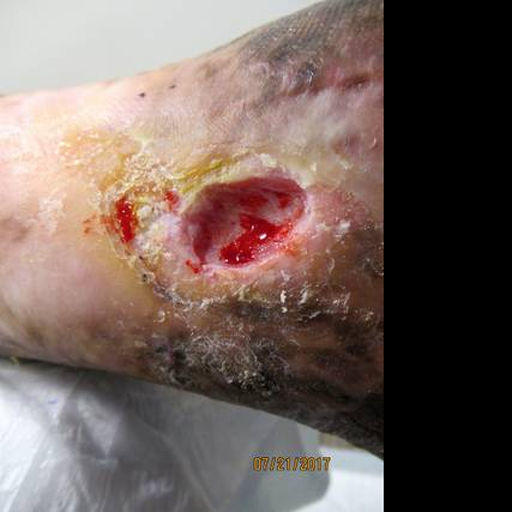

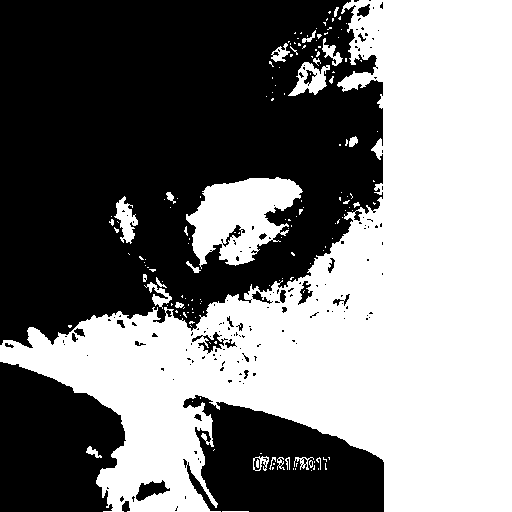

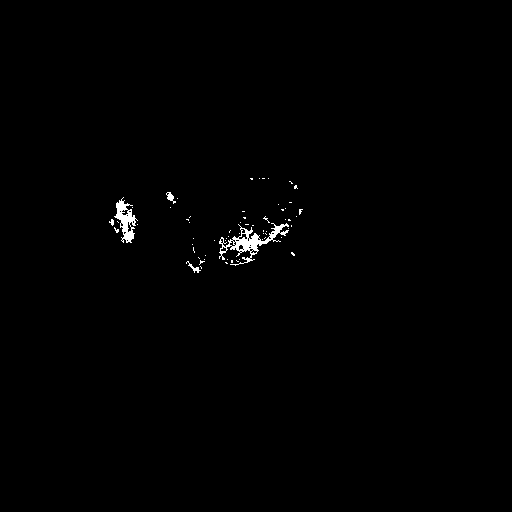

This Image Does Have Open Wounds


In [ ]:
# Classifications 1
print(woundImageDetector('1.png'))

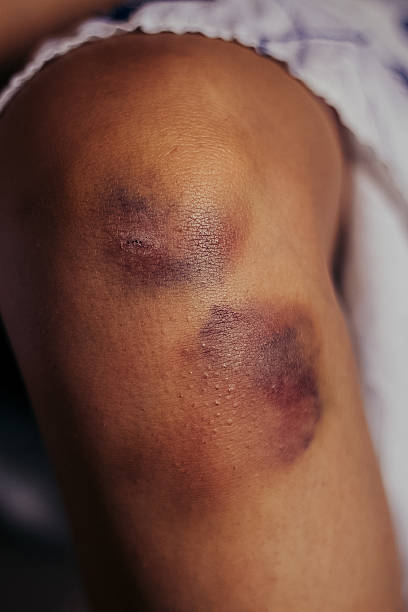

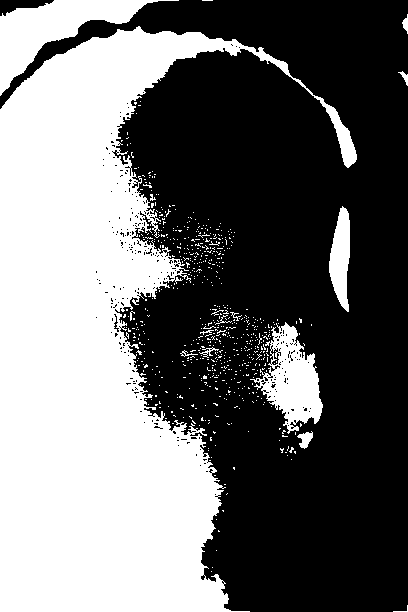

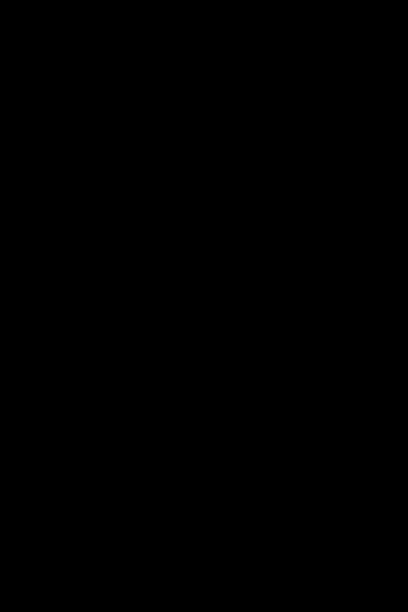

This Image Doesn't Have Open Wounds


In [ ]:
# Classifications 2
print(woundImageDetector('2.jpeg'))

#Pre-processing
Before we can apply any image processing techniques, we need to pre-process the image to make it easier to work with. This may include steps such as converting the image to grayscale, smoothing it to reduce noise, and adjusting the contrast to improve the visibility of the wound.

In [ ]:
# Load the image and convert it to grayscale
img = cv.imread('valwound5.png')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)


# Smooth the image to reduce noise
gray = cv.GaussianBlur(gray, (3, 3), 0)

# Enhance the contrast of the image
gray = cv.equalizeHist(gray)

# Segmentation with Otsu Thresholding
Next, we need to segment the image to identify the region of the wound. Otsu thresholding is a commonly used method for automatic image segmentation. It uses a threshold value to separate the image into two classes: foreground (the wound) and background (the surrounding tissue).

In [ ]:
# Apply Otsu thresholding to segment the image
ret, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Feature extraction
Once we have segmented the image, we can extract features from the wound region. These features will be used as input to the SVM classifier. In this example, we will extract the following features:

The mean and standard deviation of the pixel intensities in the wound region
The aspect ratio of the bounding box around the wound

In [ ]:
# Compute the moments of the thresholded image
moments = cv.moments(thresh)

# Extract the spatial moments
hu_moments = cv.HuMoments(moments)

# Compute the bounding box of the wound region
x, y, w, h = cv.boundingRect(thresh)

# Compute the aspect ratio of the bounding box
aspect_ratio = w / h

# Extract the features
features = [np.mean(gray[thresh > 0]), np.std(gray[thresh > 0]), aspect_ratio]

# Classification with SVM
Now we can use the extracted features to classify the wound as open or closed. For this, we will use a support vector machine (SVM) classifier. First, we need to train the SVM using labeled training data.



In [ ]:
import glob
import cv2
from sklearn.svm import SVC
from sklearn.metrics import classification_report

x_train = []
for entry in glob.glob('train/not wounded/*.jpg'):
  img = cv2.imread(entry)
  resized_img = cv2.resize(img,(64,128))                                           #resize
  grayscale = cv2.cvtColor(np.array(resized_img),cv2.COLOR_BGR2GRAY);              #grayscaling
  equ = cv2.equalizeHist(grayscale)                                                #histogram equalization
  xp = [0, 64, 128, 192, 255]                                                      #contrast stretching
  fp = [0, 16, 128, 240, 255]
  x = np.arange(256)
  table = np.interp(x, xp, fp).astype('uint8')
  result = cv2.LUT(equ, table)
  fd = hog(result)
  x_train.append(fd)

for entry in glob.glob('train/not wounded/*.jpeg'):
  img = cv2.imread(entry)
  resized_img = cv2.resize(img,(64,128))                                           #resize
  grayscale = cv2.cvtColor(np.array(resized_img),cv2.COLOR_BGR2GRAY);              #grayscaling
  equ = cv2.equalizeHist(grayscale)                                                #histogram equalization
  xp = [0, 64, 128, 192, 255]                                                      #contrast stretching
  fp = [0, 16, 128, 240, 255]
  x = np.arange(256)
  table = np.interp(x, xp, fp).astype('uint8')
  result = cv2.LUT(equ, table)
  fd = hog(result)
  x_train.append(fd)

for entry in glob.glob('train/wounded/*.png'):
  img = cv2.imread(entry)
  resized_img = cv2.resize(img,(64,128))                                           #resize
  grayscale = cv2.cvtColor(np.array(resized_img),cv2.COLOR_BGR2GRAY);              #grayscaling
  equ = cv2.equalizeHist(grayscale)                                                #histogram equalization
  xp = [0, 64, 128, 192, 255]                                                      #contrast stretching
  fp = [0, 16, 128, 240, 255]
  x = np.arange(256)
  table = np.interp(x, xp, fp).astype('uint8')
  result = cv2.LUT(equ, table)
  fd = hog(result)
  x_train.append(fd)

train_data = x_train
print(len(train_data))

10


In [ ]:
y_train = []
for i in range(len(train_data)):
  if i<5:
    y_train.append('not wounded')
  else:
    y_train.append('wounded')
print(y_train)
print(len(y_train))

['not wounded', 'not wounded', 'not wounded', 'not wounded', 'not wounded', 'wounded', 'wounded', 'wounded', 'wounded', 'wounded']
10


In [ ]:
x_valid = []
for entry in glob.glob('valid/not wounded/*.jpeg'):
  img = cv2.imread(entry)
  resized_img = cv2.resize(img,(64,128))                                           #resize
  grayscale = cv2.cvtColor(np.array(resized_img),cv2.COLOR_BGR2GRAY);              #grayscaling
  equ = cv2.equalizeHist(grayscale)                                                #histogram equalization
  xp = [0, 64, 128, 192, 255]                                                      #contrast stretching
  fp = [0, 16, 128, 240, 255]
  x = np.arange(256)
  table = np.interp(x, xp, fp).astype('uint8')
  result = cv2.LUT(equ, table)
  fd = hog(result)
  x_valid.append(fd)

for entry in glob.glob('valid/wounded/*.png'):
  img = cv2.imread(entry)
  resized_img = cv2.resize(img,(64,128))                                           #resize
  grayscale = cv2.cvtColor(np.array(resized_img),cv2.COLOR_BGR2GRAY);              #grayscaling
  equ = cv2.equalizeHist(grayscale)                                                #histogram equalization
  xp = [0, 64, 128, 192, 255]                                                      #contrast stretching
  fp = [0, 16, 128, 240, 255]
  x = np.arange(256)
  table = np.interp(x, xp, fp).astype('uint8')
  result = cv2.LUT(equ, table)
  fd = hog(result)
  x_valid.append(fd)

test_data = x_valid
print(len(test_data))

10


In [ ]:
y_valid = []
for i in range(len(test_data)):
  if i<5:
    y_valid.append('not wounded')
  else:
    y_valid.append('wounded')
print(y_valid)
print(len(y_valid))

['not wounded', 'not wounded', 'not wounded', 'not wounded', 'not wounded', 'wounded', 'wounded', 'wounded', 'wounded', 'wounded']
10


In [ ]:
# Create the SVM classifier
clf = svm.SVC(gamma='scale')

# Train the classifier
clf.fit(x_train, y_train)

SVC()

In [ ]:
y_pred = clf.predict(x_valid)

In [ ]:
from sklearn import metrics
print('Akurasi: ', metrics.accuracy_score(y_valid, y_pred))
print('F1 Score: ', metrics.f1_score(y_valid, y_pred, average='weighted'))

Akurasi:  0.7
F1 Score:  0.6969696969696969


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_euclidean = KNeighborsClassifier(n_neighbors=2)
knn_euclidean.fit(x_train, y_train)
y_pred1 = knn_euclidean.predict(x_valid)

In [ ]:
print('Akurasi: ', metrics.accuracy_score(y_valid, y_pred1))
print('F1 Score: ', metrics.f1_score(y_valid, y_pred1, average='weighted'))

Akurasi:  0.6
F1 Score:  0.5833333333333333


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_manhattan= KNeighborsClassifier(n_neighbors=2, p=1)
knn_manhattan.fit(x_train, y_train)
y_pred2 = knn_manhattan.predict(x_valid)

In [ ]:
print('Akurasi: ', metrics.accuracy_score(y_valid, y_pred2))
print('F1 Score: ', metrics.f1_score(y_valid, y_pred2, average='weighted'))

Akurasi:  0.5
F1 Score:  0.45054945054945056


# ANN Method

In [ ]:
# Pre-process the image using Gaussian blur
image = cv.imread('valwound5.png')
blurred = cv.GaussianBlur(image, (5, 5), 0)

# Segment the image using Otsu's thresholding algorithm
gray = cv.cvtColor(blurred, cv.COLOR_BGR2GRAY)
threshold, mask = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# Extract features using edge detection and morphological operations
edges = cv.Canny(mask, threshold, threshold * 2)
kernel = np.ones((3, 3), np.uint8)
closed = cv.morphologyEx(edges, cv.MORPH_CLOSE, kernel)

# Use an artificial neural network to classify the wound
ann = cv.ml.ANN_MLP_create()
# Train the ANN on a dataset of labeled images
ann.train('Test/wounded')
# Predict the label of the input image
label = ann.predict(closed)

error: ignored